In [2]:
# # Install needed libraries
# !python -m pip install pandas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def scale_data(value, minimum, maximum):
    return (value - minimum) * (180 / (maximum - minimum))

def scrub_data(df):
    df['div_crank'] = np.abs(np.diff(df['crank_deg'], prepend=df['crank_deg'].iloc[0]))
    df['crank_ang'] = ''
    df['stage'] = ''
    df['cycle'] = ''
    counter = 0
    cycle_count = 1
    for i in range(len(df['crank_deg'])):
        if counter == 4:
            counter = 0
            cycle_count += 1
        if df.loc[i, 'div_crank'] > 100:
            counter += 1
        df.loc[i, 'stage'] = counter
        df.loc[i, 'cycle'] = cycle_count
    # Add 0 for piston in stage 0 and 1
    df.loc[(df['stage'] == 0) | (df['stage'] == 1), 'crank_ang']= df['crank_deg']
    # Add 360 for piston in stage 2 and 3
    df.loc[(df['stage'] == 2) | (df['stage'] == 3), 'crank_ang'] = df['crank_deg'] + 360
    # Add 720 for piston in stage 4
    df.loc[df['stage'] == 4, 'crank_ang']= df['crank_deg'] + 720
    return df

def clean_data(df):
    df['pressure_bar'] = df['pressure_v'] * 10.2
    df_min = min(df["crank_v"])
    df_max = max(df["crank_v"])
    df['crank_deg'] = scale_data(df['crank_v'], df_min, df_max)
    df = scrub_data(df)
    return df

def select_cycles(df, list):
    df = df[df['cycle'].isin(list)]
    return df

# Load Data
## Load data will look for cleaned data, if cleaned data does not exist, it will look for raw data. 
## Raw data will be cleaned and returned as a Pandas Dataframe. A csv file will also be created with cleaned data. 
## Parsing raw data will take about 30 seconds
def load_data(csv_name, txt_name):
    try:
        df = pd.read_csv(csv_name)
        print(f"Found {csv_name}, CSV converted into dataframe.")
        return df
    except FileNotFoundError:
        try:
            print(f"{csv_name} not found. Will try to load {txt_name} raw data, clean, and create new csv.")
            # Time [s], Crank Angle [V], Pressure [V]
            df = pd.read_csv(txt_name, sep='\t', names=['time', 'crank_v', 'pressure_v'])
            print(f"{txt_name} file found, processing data and converting to dataframe.")
            df = clean_data(df)
            df.to_csv(csv_name, index=False)
            print("Returned as Pandas Dataframe. New CSV file created and loaded to current directory")
            return df
        except FileNotFoundError:
            print(f"{txt_name} raw data not found, please put {txt_name} file in same directory as this ipynb file.")
            return False

In [8]:
cd1700 = load_data("clean_1700.csv",'1700_001.txt')
cd2730 = load_data("clean_2730.csv",'2750_001.txt')
cd4500 = load_data("clean_4500.csv",'4500_001.txt')
try:
    engine_df = pd.read_csv("EngineData.txt", sep='\t')
except FileNotFoundError:
        print("Engine Data file found. Make sure file is in same directory and name is correct.")

Found clean_1700.csv, CSV converted into dataframe.
Found clean_2730.csv, CSV converted into dataframe.
Found clean_4500.csv, CSV converted into dataframe.


*** DATA SET 1700 ***
Number of Cycles:  2972
Highest Pressure Reached:  31.771551599999995
Average Pressure:  5.26494818259
   cycle  stage   crank_ang  pressure_bar
0      1      0    2.991686      1.773515
1      1      1  146.159725      1.770159
2      1      1  176.594731      1.773515
3      1      1  177.552123      1.773515
4      1      1  176.839507      1.776871


(-50.0, 1000.0)

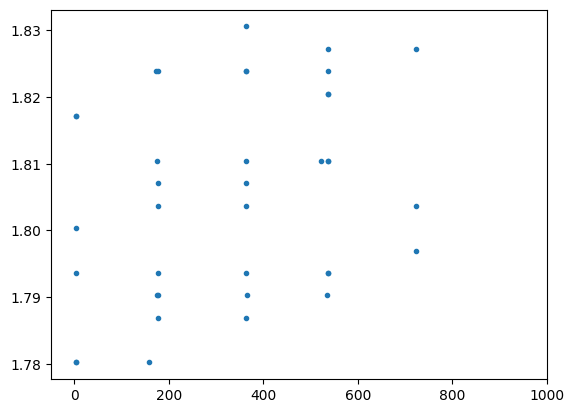

In [5]:
print("*** DATA SET 1700 ***")
print("Number of Cycles: ", max(cd1700['cycle']))
print("Highest Pressure Reached: ", max(cd1700['pressure_bar']))
print("Average Pressure: ", sum(cd1700['pressure_bar'])/len(cd1700['pressure_bar']))

eng1_data = engine_df.iloc[0]
load = eng1_data["Load"]
espeed = eng1_data["Engine Speed (rpm)"]
torque = eng1_data["Torque (lb-f)"]
power = eng1_data["Power (hp)"]
time_2_leave = eng1_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng1_data["Air Flow Rate (CFM)"]
air_in_temp = eng1_data["Air Intake Temperature (F)"]

# Select only wanted columns
cd1700 = cd1700[['cycle','stage','crank_ang','pressure_bar']]
print(cd1700.head())

# Select by cycle number
df = select_cycles(cd1700, [5,6,7])

# Select which cycles need to be plotted
plt.scatter(df['crank_ang'],df['pressure_bar'], marker='.')
plt.xlim((-50,1000))

*** DATA SET 2730 ***
Number of Cycles:  5906
Highest Pressure Reached:  38.63614139999999
Average Pressure:  1.59826272276


   cycle  stage   crank_ang  pressure_bar
0      1      0  162.910039     -2.128475
1      1      0  165.788741     -2.121763
2      1      1    0.171280     -2.125119
3      1      2  516.097309     -2.118407
4      1      2  527.186662     -2.148599


(-50.0, 1000.0)

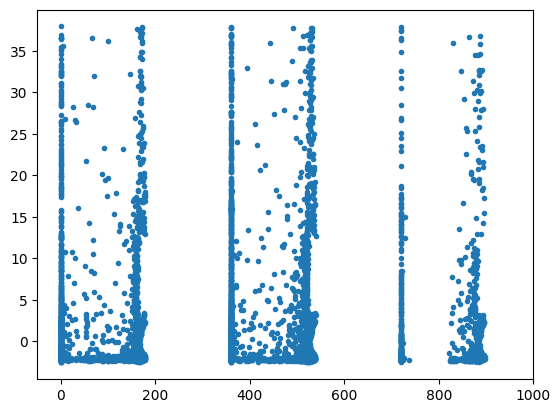

In [6]:
print("*** DATA SET 2730 ***")
print("Number of Cycles: ", max(cd2730['cycle']))
print("Highest Pressure Reached: ", max(cd2730['pressure_bar']))
print("Average Pressure: ", sum(cd2730['pressure_bar'])/len(cd2730['pressure_bar']))

eng2_data = engine_df.iloc[1]
load = eng2_data["Load"]
espeed = eng2_data["Engine Speed (rpm)"]
torque = eng2_data["Torque (lb-f)"]
power = eng2_data["Power (hp)"]
time_2_leave = eng2_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng2_data["Air Flow Rate (CFM)"]
air_in_temp = eng2_data["Air Intake Temperature (F)"]

# Select only wanted columns
cd2730 = cd2730[['cycle','stage','crank_ang','pressure_bar']]
print(cd2730.head())

# Select by cycle number
df = select_cycles(cd2730, list(range(1000)))

# Select which cycles need to be plotted
plt.scatter(df['crank_ang'],df['pressure_bar'], marker='.')
plt.xlim((-50,1000))

*** DATA SET cd4500 ***
Number of Cycles:  8740
Highest Pressure Reached:  52.2512952
Average Pressure:  6.1714948096499995
   cycle  stage   crank_ang  pressure_bar
0      1      0  153.560505      4.460950
1      1      1    0.446993      4.450882
2      1      1    0.430434      4.575026
3      1      1    0.402837      4.564959
4      1      2  520.381423      4.642122


(-50.0, 1000.0)

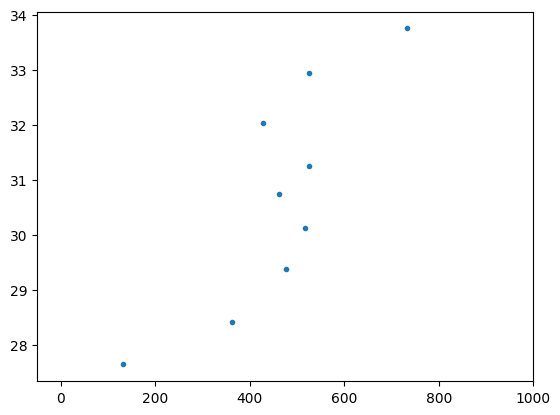

In [7]:
print("*** DATA SET cd4500 ***")
print("Number of Cycles: ", max(cd4500['cycle']))
print("Highest Pressure Reached: ", max(cd4500['pressure_bar']))
print("Average Pressure: ", sum(cd4500['pressure_bar'])/len(cd4500['pressure_bar']))

eng3_data = engine_df.iloc[2]
load = eng3_data["Load"]
espeed = eng3_data["Engine Speed (rpm)"]
torque = eng3_data["Torque (lb-f)"]
power = eng3_data["Power (hp)"]
time_2_leave = eng3_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng3_data["Air Flow Rate (CFM)"]
air_in_temp = eng3_data["Air Intake Temperature (F)"]

# Select only wanted columns
cd4500 = cd4500[['cycle','stage','crank_ang','pressure_bar']]
print(cd4500.head())

# Select by cycle number
df = select_cycles(cd4500, list(range(1002, 1003)))

# Select which cycles need to be plotted
plt.scatter(df['crank_ang'],df['pressure_bar'], marker='.')
plt.xlim((-50,1000))